In [1]:
import os
import time

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW, Adam

In [3]:
class Config:
    csv_path = ''
    seed = 2021
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

def seed_everything(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    
config = Config()
seed_everything(config.seed)
config.device

'cuda:0'

In [4]:
!nvidia-smi

Thu Nov  6 16:22:40 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.95.05              Driver Version: 580.95.05      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A6000               Off |   00000000:01:00.0 Off |                  Off |
| 38%   57C    P3             30W /  300W |    1743MiB /  49140MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
path = "./ECG_DATASET/dataset_ekg_df.csv"
config.csv_path = path

config.csv_path

'./ECG_DATASET/dataset_ekg_df.csv'

In [6]:
df = pd.read_csv(config.csv_path)

Text(0.5, 0, 'muestras')

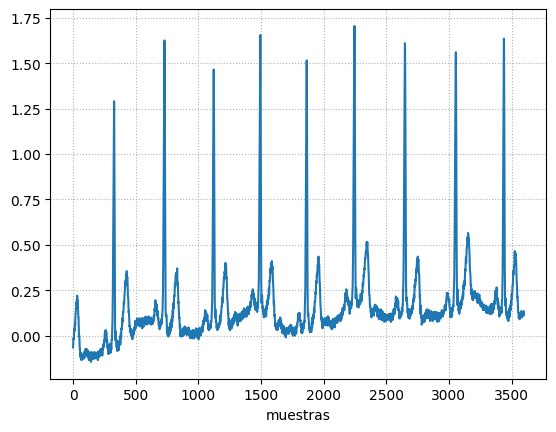

In [7]:
df[df["label"]=="NSR"].iloc[0,:-2].plot()
plt.grid(ls=":")
plt.xlabel("muestras")

## Creación del DATALOADER

In [8]:
class ECGDataset(Dataset):

    def __init__(self, df):
        self.df = df
        self.data_columns = self.df.columns[:-2].tolist()
        # Pre-convertir los datos a arrays numpy para evitar warnings
        self.signals = self.df[self.data_columns].values.astype('float32')
        self.targets = self.df['class'].values.astype('int64')

    def __getitem__(self, idx):
        signal = torch.from_numpy(self.signals[idx]).unsqueeze(0)
        target = torch.tensor(self.targets[idx], dtype=torch.long)
        return signal, target

    def __len__(self):
        return len(self.df)

def get_dataloader(label_name, batch_size):
    df = pd.read_csv(config.csv_path)
    df = df.loc[df['label'] == label_name]
    df.reset_index(drop=True, inplace=True)
    dataset = ECGDataset(df)
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, num_workers=0)
    return dataloader

In [9]:
dataloader = get_dataloader(label_name='NSR', batch_size=96)

print(len(dataloader))
x,y = next(iter(dataloader))
x.shape, y.shape

3


(torch.Size([96, 1, 3600]), torch.Size([96]))

## CREACION DEL WGAN-GP